<h1> Monte Carlo Markov Chains and Cluster Mass Reconstruction </h1>

for questions, problems or suggestions: contact Kerstin Paech (kerstin.paech@physik.lmu.de)

In [1]:
#import some modules for math and integrations
from scipy import integrate, constants, optimize
import numpy as np
import timeit
%matplotlib inline
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from tqdm import tqdm
figsize = (18,6)
figsize_narrow = (9,6)

<h2> A small primer on classes in Python</h2>

In this lab, we will be using classes to manage our data and the functions that operate on the data.
__If you need any clarification on this subject, please talk to your supervisor.__

The following cell contains the Cluster class. Among other things, it can read the data and calculate model values for a given set of parameters. Familiarize yourself with all the functions and variables that are defined before you proceed with the coding exercise.

Before you can use your class in this lab, you need to *instantiate* it (you strictly don't need to instantiate a class, but for this lab we'll ignore this option). For example my_instance = MyClass() creates a new instance of a 
class and you can access its functions via my_instance.my_function() and variables via my_instance.my_variable. Don't worry too much what an instance acutally is at this point. Just think initialize instead of instantiate if it causes any confusion.

As soon as a new instance is created, the `__init__`() function is invoked (if available) to initalise the class and put everyhing into place. As you will see, in our case `__init__`() reads in the data and defines the cosmology.

<h2>$\chi^2$ Calculation</h2>

The Cluster class contains all function necessary to calculate the  goodness-of-fit for a given set halo of mass and concentration $(M,c)$. We define the quadratic deviations from the measured shear values:

$$ \chi^2(M,c) = \sum_i^N \frac{(\gamma_\mathrm{theo, i}(M,c) - \gamma_\mathrm{dat, i})^2}{\sigma^2_\gamma} $$

The theoretical shear values are calculated by assuming a Navarro-Frenk-White (NFW) density profile:

$$ \rho_\mathrm{NFW}(r) = \frac{\delta_c \rho_c}{(r/r_s)(1 + r/r_s)^2} \: , $$

which leads to

$$ \gamma(x_i) = \frac{r_s(M,c) \; \delta_c(c) \; \rho_c(z_\mathrm{lens})}{\Sigma_c(z_\mathrm{lens},z_\mathrm{source})} g(x_i) \: , $$

where $g(x)$ is an auxiliary function for the dimensionless distance from the lens $x = \theta/\theta_s$. 

Be careful to distinguish $g(x)$ for the cases $x<1$ and $x>1$. When calculating $\chi^2$. Do not use loops over the whole data array - they are quite slow in python. Numpy arrays however do support fast vectorized operations. A term to look for is "boolean arrays".

Speed matters here. Try to optimise your $\chi^2$ calculation, remember that this routine is called several thousand times when used as part of a chain. You can check your execution time with the `%timeit my_function(x,y,..)` command.

Now your first task is to complete the Cluster class. If you try to use it as it is, it will produce error messages. From these error messages, work your way back through the code and try to figure out what is still missing. But check out the next few cells before you begin.

The likelihood function you will need later on is log_prob - it returns the log-likelihood for the cluster. This is what libraries like emcee (https://emcee.readthedocs.io/en/stable/) expect as input.

In [3]:
class Cluster:
    ckms = constants.c/1000. # speed of light in km/s 
    G = 4.30091e-9 # G in units of Mpc/Msun /(km/s)^2
    
    def __init__(self, data_filename='halo5.tab', Omega_m=0.27):
        """
        Initialise arrays and variables.
        
        Optional parameter:
        ----------
        data_filename : the filename that contains the shear data. Defaults to 'halo5.tab'

        """
        # instance variables
        self.shear_err = 0.3 # all data points have the same error
        self.zlens = 0.245
        self.zsource = 1.0 # all data points have the same redshift

        self.Omega_m = Omega_m
        self.Omega_L = 1.0 - Omega_m #assumes flatness
        self.rho_crit0 = 2.7751973751261264e11 # rho_crit(z=0) in units of h^-1 Msun/ h^-3 Mpc^3

        
        self.rho_crit_zlens = self.rho_crit0 * self.E(self.zlens)**2
        self.r, self.shear = self.read_data(data_filename)
        self.set_parameter_limits()
        
    def read_data(self, data_filename):
        """
        Reads in the cluster dat.

        Parameters:
        ----------
        data_filename : the filename that contains the shear data. Defaults to 'halo5.tab'

        Returns:
        ----------
        r : radial distance between source and lens
        """
        # read angular distance in arcmin and measured shear signal
        theta, shear = np.loadtxt(data_filename, usecols = (3,5), unpack=True)
        r = self.angular_distance(self.zlens)*theta*np.pi/180.0/60.0 # physical distance
        return r, shear
    
    def set_parameter_limits(self, logM200_min=14, logM200_max=16, c200_min=2, c200_max=10):
        """
        Set the parameter limits for the cluster model

        Optional Parameters:
        ----------
        logM200_min [default: 10]
        logM200_max [default: 20]
        c200_min [default: 0.1]
        c200_max [default: 10]
        
        """
        self.par_min = [logM200_min, c200_min] 
        self.par_max = [logM200_max, c200_max]

    def get_random_parameter(self, logM200_min=None, logM200_max=None, c200_min=None, c200_max=None):
        """
        Return randomly chosen parameters within a given range.

        Optional Parameters:
        ----------
        logM200_min [default: None]
        logM200_max [default: None]
        c200_min [default: None]
        c200_max [default: None]
        
        """
        par_min = self.par_min.copy()
        par_max = self.par_max.copy()
        if logM200_min:
            par_min[0] = logM200_min
        if logM200_max:
            par_max[0] = logM200_max
        if c200_min:
            par_min[1] = c200_min
        if c200_max:
            par_max[1] = c200_max
        
        return np.random.uniform(par_min, par_max)
    
    def E(self, z):
        """
        Calculates the dimensionless Hubble function.

        Parameters:
        ----------
        z : redshift

        Returns:
        ----------
        E(z) : Dimensionless Hubble function E(z)=H(z)/H0
        """
        E = np.sqrt(self.Omega_m*(1.+z)**3 + self.Omega_L)
        return E

    def angular_distance(self,z):
        """
        Calculates angular diameter distances. Assumes a fixed LCDM cosmology
        defined in the Cosmology class.

        Parameters:
        ----------
        z : redshift

        Returns :
        ----------
        d_A(z) : angular diameter distance in Mpc/h
        """
        integral, error = integrate.quad(self.integrand_angular_distance,0.,z,epsrel=1e-4)
        d_A = integral * self.ckms*1e-2/(1.+z)
        return d_A

    def integrand_angular_distance(self,z):
        """
        Integrand for the angular diameter distance calculation.

        Parameters:
        ----------
        z : redshift

        Returns:
        ----------
        1./E(z) : Inverse dimensionless Hubble function 1./E(z)=H0/H(z)
        """
        return 1./self.E(z)

    def Sigma_critical(self,z_lens,z_source):
        """
        Calculates the critical surface density.

        Parameters:
        ----------
        z_lens    : lens redshift
        z_source  : source redshift

        Returns:
        ----------
        Sigmac : critical surface density
        """
        D_source = self.angular_distance(z_source)
        D_lens = self.angular_distance(z_lens)
        D_lens_source = D_source - (1.0+z_lens)*D_lens/(1.+z_source)    
        Sigmac = self.ckms**2*D_source/D_lens/D_lens_source/np.pi/self.G/4.
        return Sigmac

    def g_less(self,x):
        """
        Auxiliary function g(x) for shear calculation, assumes x < 1.

        Parameters:
        ----------
        x : array_like, dimensionless radial distance between source and lens

        Returns:
        ----------
        result : array_like with same shape as x, analytic shear
                 integral for a NFW density profile
        """
        arctan = np.arctanh(np.sqrt((1.-x)/(1.+x)))
        x_sq = x*x
        term1 = 8.*arctan/x_sq/np.sqrt(1.-x_sq) + 4./x_sq*np.log(x/2.) - 2./(x_sq-1)
        result = (term1 + 4.*arctan/(x_sq-1.)/np.sqrt(1.-x_sq))
        return result

    def g_larger(self,x):
        """
        Auxiliary function g(x) for shear calculation, assumes x > 1.

        Parameters:
        ----------
        x : array_like, dimensionless radial distance between source and lens

        Returns:
        ----------
        result : array_like with same shape as x, analytic shear
                 integral for a NFW density profile
        """
        arctan = np.arctan(np.sqrt((x-1.)/(1.+x)))
        x_sq = x*x
        term1 = 8.*arctan/x_sq/np.sqrt(x_sq-1.) + 4./x_sq*np.log(x/2.) - 2./(x_sq-1)
        result = (term1 + 4.*arctan/(x_sq-1.)**1.5)
        return result

    def get_model_values(self, M200, c200):
        """
        Calculates the modeled shear values for each of the given data points

        Parameters:
        ----------
        M200    : cluster mass
        c200    : cluster concentration

        Returns:
        ----------
        model : array with the modeled shear values
        """
        
        #raise Exception("get_model_values is not implemented yet.")
        # TODO: 
        # - calculate scale radius rs and x = r/rs
        # - call g_less and g_larger depending on the condition if x larger or smaller 1
        # - calculate shear
        x = self.r/self.scale_radius_nfw(M200,c200)
        model = np.ones(len(x)) * (self.scale_radius_nfw(M200,c200) * self.delta_c(c200) * self.rho_crit_zlens) / self.Sigma_critical(self.zlens,self.zsource)
        #if x<1:
        model[np.where(x<1)] *= self.g_less(x[np.where(x<1)])
        #if x == 1:
        model[np.where(x==1)] *= (10./3. - 4. * np.log(2.)) 
        #else:
        model[np.where(x>1)] *= self.g_larger(x[np.where(x>1)])
            
        return model
    
    def chi_sq(self, y_model, y_data, y_err):
        """
        Generic function that calculates the chi square

        Parameters:
        ----------
        y_model   : values for the model
        y_data    : measured data points
        y_err     : error of the measured data points

        Returns:
        ----------
        chi square for the data and model provided
        """
        #raise Exception("chi_sq is not implemented yet.")
        # TODO: calculate chi_sq for the data and model vectors given
        # It should be a generic function an not "know" anything about 
        # the specifics of the data or the model - that is the role of log_prob
        chi = (y_model - y_data) / y_err 

        return np.sum(chi**2)
    
    def log_prob(self, logM200, c200, normalize=False):
        """
        Calculates the log of the likelihood for a given set of parameters

        Parameters:
        ----------
        logM200   : log10 of the cluster mass
        c200      : cluster concentration

        Returns:
        ----------
        log-likelihood of the data
        """
       
        # check if parameters are outside of the prior range
        if self.outside_param_range([logM200, c200]):
            return float('inf')
        M200 = 10**logM200
        y_model = self.get_model_values(M200, c200)
        y_data = self.shear
        y_err = self.shear_err
        log_prob = self.chi_sq(y_model, y_data, y_err)
        if normalize:
            ndof = len(y_data)-2
            log_prob /= ndof
        return log_prob

    def outside_param_range(self, p):
        """
        Check if current parameter vector x is in the allowed range, i.e. outside of Prior or not
        """
        for ip, ip_min, ip_max in zip(p, self.par_min, self.par_max):
            if ip < ip_min: 
                return True
            if ip > ip_max:
                return True
            
        return False
    
    def scale_radius_nfw(self,M200,c200):
        """
        Calculates scale radius of a NFW profile.

        Parameters:
        ----------
        M200 : Mass of the lens enclosed within a radius r200 where the mean density is 200 times
               larger than the background matter density
        c200 : Halo concentration at radius r200

        Returns:
        ----------
        r_s : scale radius
        """            
        r_s = (3.0*M200/800.0/np.pi/self.rho_crit_zlens/c200**3)**(1./3.)
        return r_s

    def delta_c(self,c200):
        """
        Calculates the central density contrast for a NFW profile.

        Parameters:
        ----------
        c200 : Halo concentration at radius r200

        Returns:
        ----------
        delta_c : central density contrast 
        """    
        delta_c = 200.*c200**3/(np.log(1.+c200) - c200/(1.+c200))/3.
        return delta_c

    

Before we start working on our likelihood/chi square, we will do one other thing. The data file is very large and takes a long time to load - which can be a bit annoying when developing/testing your code. Therefore we'll first create a smaller data file that you can use while developing your code.

In [3]:
def create_small_data_file(input_filename, output_filename, size):
    data = np.loadtxt(input_filename)
    idx = np.arange(data.shape[0], dtype=int)
    np.random.shuffle(idx)
    idx_small = idx[:size]
    np.savetxt(output_filename, data[idx_small, :])
    return

You have to choose how large your small file should be. For checking if everything is running, a small size is fine. But if you would like to check if your likelihood returns sensible numbers, a larger size is better. When you have done all check or you think you need all the data move to the full data file.

In [4]:
size = 10
filename = 'halo5.tab'
filename_small = f'halo5_{size}.tab'
create_small_data_file(filename, filename_small, size)

Once you have generated a small file, get an instance of the cluster class - this contains all the information about the data and the cluster model. Once you have the instance, you can try calculating a posterior for a given set of parameters. 

Now it's time to start completing the cluster class. Try out the log_prob function for parameter values both inside and outside the prior range - start with inside the prior range.

In [5]:
"Put your code here"
cluster = Cluster(filename_small)
#cluster.set_parameter_limits()
M200, c200 = cluster.get_random_parameter()
model = cluster.get_model_values(M200,c200)
chi = cluster.chi_sq(model,cluster.shear,cluster.shear_err)
print(chi)
cluster.log_prob(M200, c200)

9.787794630455547


9.760893517700756

Now it's time to check if your likelihood is fast enough - so you have to use the full data set.

In [ ]:
"Put your code here"
cluster = Cluster()
cluster.set_parameter_limits()
M200, c200 = cluster.get_random_parameter()
#model = cluster.get_model_values(M200,c200)
#chi = cluster.chi_sq(model,cluster.shear,cluster.shear_err)
%timeit cluster.log_prob(M200, c200)

Let's take a first look at the posterior for a range of parameter values. In order to do so, implement loops over $\log M_{200}$ and $c_{200}$ with fixed step sizes. While you're at it, determine the parameters corresponding to the minimal $\chi^2$. Determining the best fit parameters that way is called a grid search. 

Eventually on often chooses the same number of grid points for all parameters, however while developing your code, choose a different number of grid points for $\log M_{200}$ and $c_{200}$. Index order is important and different library functions you use will have different conventions and this way you will get an error if you got it wrong.

Plot your results to get a rough idea for the shape of $\chi^2$. 

First make two plots: one where you fix $c_{200}$ to the best fit value and vary $\log M_{200}$. And a second one where you fix $\log M_{200}$ to the best fit value and vary $c_{200}$. This way you can varify that the $\chi^2$ has the right shape and looks sensible. This is much harder to tell in a 2-d color plot.

When you think everything looks good, make two 2-d plots, one for $\chi^2$ and one for the likelihood. You may need to adjust parameter ranges for your parameters to identify the minimum/maximum visually.

In [4]:
class Grid_Search:
    def __init__(self, func, n_x, n_y, par_min, par_max, p_names):
        """
        Initialise arrays and variables and perform grid search.
        
        Parameters:
        ----------
        func: function for which the grid search is performed
        n_x : number of grid steps of first parameter
        n_y : number of grid steps of second parameter
        par_min : list with minimum values of parameters
        par_max : list with maximum values of parameters
        p_names : list with parameter names (for plotting)
        """
        x_min, y_min = par_min
        x_max, y_max = par_max

        chi_sq_array = np.zeros((n_x, n_y))

        x_edges = np.linspace(x_min, x_max, n_x+1)
        y_edges = np.linspace(y_min, y_max, n_y+1)
        
        x_centers = 0.5*(x_edges[1:]+x_edges[:-1])
        y_centers = 0.5*(y_edges[1:]+y_edges[:-1])
        
        #raise Exception("grid search loop is not implemented yet.")
        # TODO: 
        # - implement the loops over the parameters
        # - the the indices of the minimum chi square, i_min and j_min
        # - "normalize" the chi square so that the log-likelihood will be equal to one at its maximum

        for i in range(n_x):
            for j in range(n_y):
                chi_sq_array[i,j] = func(x_centers[i],y_centers[j])
        
        i_min, j_min = np.unravel_index(np.argmin(chi_sq_array), chi_sq_array.shape)
        #chi_sq_array /= np.max(chi_sq_array)
        print(np.amin(chi_sq_array))
        chi_sq_array -= np.amin(chi_sq_array)
        self.chi_sq = chi_sq_array
        self.x = x_centers
        self.y = y_centers
        self.ix_min = i_min
        self.iy_min = j_min
        self.extent = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]
        self.p_names = p_names
        self.gauss_fit_done = False
        
        

    def plot1d(self, likelihood=False, axes=None, marginalize=False):
        """
        Plot the 1d-chi square around the best fit parameters
        
        Optional Parameters:
        --------------------
        likelihood : [default: False] if true, plot the likelihood instead of the chi square
        axes : pass an axes object if you'd like add the plot to an already existing one
        marginalize: [default: False] if true, marginalize instead of plotting around the best fit parameters
        """
        if axes is None:
            _, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

        x = self.x
        z = self.chi_sq
        if likelihood:
            z = np.exp(-0.5*z)
            axes[0].scatter(x, z[:,self.iy_min]);
            axes[0].set_xlabel(self.p_names[0]);
            axes[0].set_ylabel("log likelihood");
        if marginalize:
            z = np.sum(z, axis=1)
            z /= np.mean(z)*np.ptp(x)
            axes[0].plot(x, z);
            axes[0].set_xlabel(self.p_names[0]);
            axes[0].set_ylabel("chi sq (marginalize)");
        else:
            z = z[:, self.iy_min]
            axes[0].plot(x, z);
            axes[0].set_xlabel(self.p_names[0]);
            axes[0].set_ylabel("chi sq");  
        
        y = self.y
        z = self.chi_sq
        if likelihood:
            z = np.exp(-0.5*z)
            axes[1].scatter(y, z[self.ix_min,:]);
            axes[1].set_xlabel(self.p_names[1]);
            axes[1].set_ylabel("log likelihood"); 
        if marginalize:
            z = np.sum(z, axis=0)
            z /= np.mean(z)*np.ptp(y)
            axes[1].plot(y, z);
            axes[1].set_xlabel(self.p_names[1]);
            axes[1].set_ylabel("chi sq  (marginalize)"); 
        else:
            z = z[self.ix_min, :]
            axes[1].plot(y, z);
            axes[1].set_xlabel(self.p_names[1]);
            axes[1].set_ylabel("chi sq"); 
        
    
        
        return axes
    
    def plot_gauss1d(self, axes=None):
        """
        Plot the Gaussian best fit returned by the function get_gaussian_fit(). You have
        to run get_gaussian_fit() first to use this function.
        
        Optional Parameters:
        --------------------
        axes : pass an axes object if you'd like add the plot to an already existing one
        """
        if self.gauss_fit_done is False:
            raise Exception("You have to run get_gaussian_fit() before you can call this function")

        if axes is None:
            _, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
            
        x = self.x
        x = np.linspace(x.min(), x.max())
        z = self.gaussian_fit(x, 0)
        z /= np.sum(z)*np.ptp(x)/len(x)
        axes[0].plot(x, z)

        y = self.y
        y = np.linspace(y.min(), y.max())
        z = self.gaussian_fit(0, y)
        z /= np.sum(z)*np.ptp(y)/len(y)
        axes[1].plot(y, z)
        
        return axes

    
    def plot2d(self):
        """
        Plot the 2d-chi square and likelihood
        """
        
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)

        #raise Exception("plot2d is not implemented yet.")
        # TODO: Implement the plotting of the 2d chi square and likelihood
        # remember that you have to transpose 2d arrays before plotting because
        # of the different index ordering of arrays and matplotlib images
        z = self.chi_sq
        #chi_sq
        im1 = axes[0].imshow(z, cmap="coolwarm", origin='lower', aspect='auto') 
        axes[0].set_title("Chi sq Heatmap")
        axes[0].set_xticklabels(np.round(self.x, 2))  
        axes[0].set_yticklabels(np.round(self.y, 2))  
        axes[0].set_xlabel(self.p_names[0])
        axes[0].set_ylabel(self.p_names[1])
        fig.colorbar(im1, ax=axes[0], label='Chi sq Value')

 
        
        #likelihood
        z = np.exp(-0.5*z)
        im2 = axes[1].imshow(z.T, cmap="coolwarm", origin='lower', aspect='auto') 
        axes[1].set_title("Likelihood Heatmap")
        axes[1].set_xticklabels(np.round(self.x, 2))  
        axes[1].set_yticklabels(np.round(self.y, 2))  
        axes[1].set_xlabel(self.p_names[0])
        axes[1].set_ylabel(self.p_names[1])
        fig.colorbar(im2, ax=axes[1], label='Likelihood Value')

        return axes
        
    def get_gaussian_fit(self, plot=False):
        """
        Fit a Gaussian to the grid likelihood.
        
        Returns:
        ----------
        f : chi square function corresponding to Gaussian best fit 
        g : Gaussian best fit function
        """
        x = self.x
        y = self.y
        z = self.chi_sq
        
        def h(p, x, y):
            a, b, da, db = p
            aux = ((x-a)/da)**2 + ((y-b)/db)**2
            res = np.exp(-0.5*aux)
            return res

        def err_func(p, x, y, z):
            return h(p, x, y) - z

        xv, yv = np.meshgrid(x, y, indexing='ij')
        zv = z.flatten()
        zv = np.exp(-0.5*zv)
        xv = xv.flatten()
        yv = yv.flatten()

        p,_ = optimize.leastsq(err_func, [15, 2.6, 0.02, 0.2], args=(xv, yv, zv), maxfev=20000)

        def f(x, y):
            a, b, da, db = p
            res = ((x-a)/da)**2 + ((y-b)/db)**2
            return res

        def g(x, y):
            res = np.exp(-0.5*f(x,y))
            return res

        g.p = p
        f.p = p
        
        if plot:
            axes = self.plot1d(likelihood=True)
            axes[0].plot(self.x, g(self.x, self.y[self.iy_min]), label='gaussian fit')
            axes[1].plot(self.y, g(self.x[self.ix_min], self.y), label='gaussian fit')
            
        self.gaussian_fit = g
        self.chi_sq_fit = f
        self.gauss_fit_done = True
        return f, g

    

In [120]:
n_m, n_c = 100, 110# for development use n_m!=n_c
par_min = cluster.par_min
par_max = cluster.par_max
grid = Grid_Search(cluster.log_prob, n_m, n_c, par_min, par_max, ['logM', 'c'])


627643.2915456034


In [6]:
print(grid.x[grid.ix_min], grid.y[grid.iy_min])

14.99 2.618181818181818


C:\Users\pablo\AppData\Local\Temp\ipykernel_9152\2708715732.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(np.round(self.x, 2))
C:\Users\pablo\AppData\Local\Temp\ipykernel_9152\2708715732.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(np.round(self.y, 2))
C:\Users\pablo\AppData\Local\Temp\ipykernel_9152\2708715732.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(np.round(self.x, 2))
C:\Users\pablo\AppData\Local\Temp\ipykernel_9152\2708715732.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(np.round(self.y, 2))


array([<Axes: title={'center': 'Chi sq Heatmap'}, xlabel='logM', ylabel='c'>,
       <Axes: title={'center': 'Likelihood Heatmap'}, xlabel='logM', ylabel='c'>],
      dtype=object)

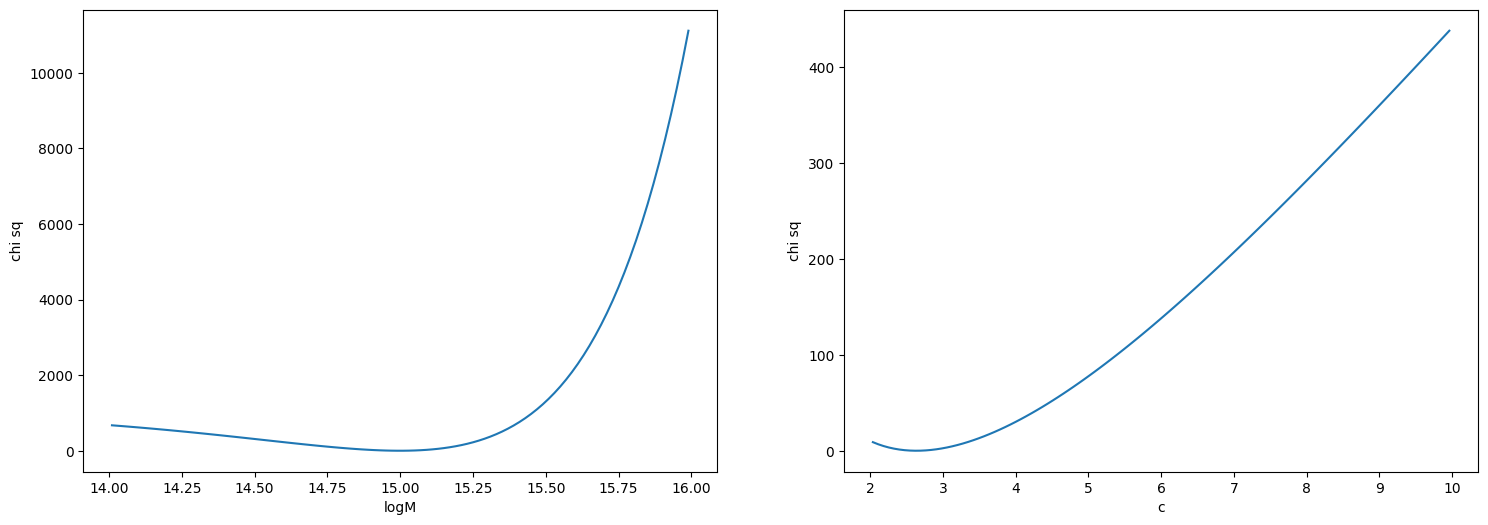

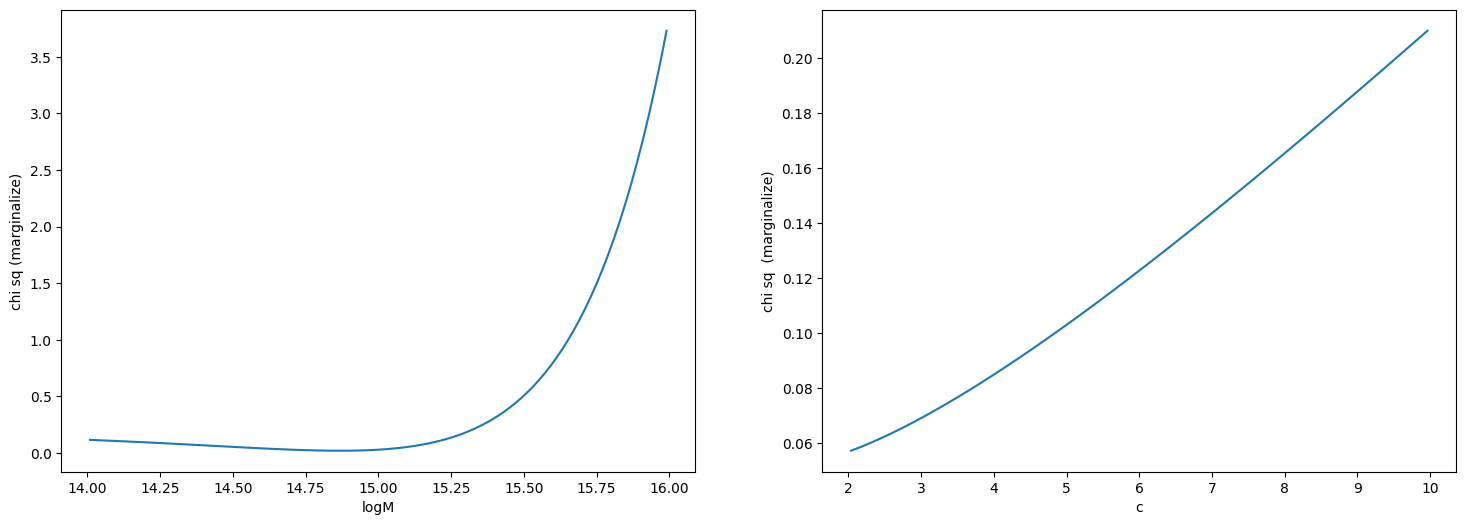

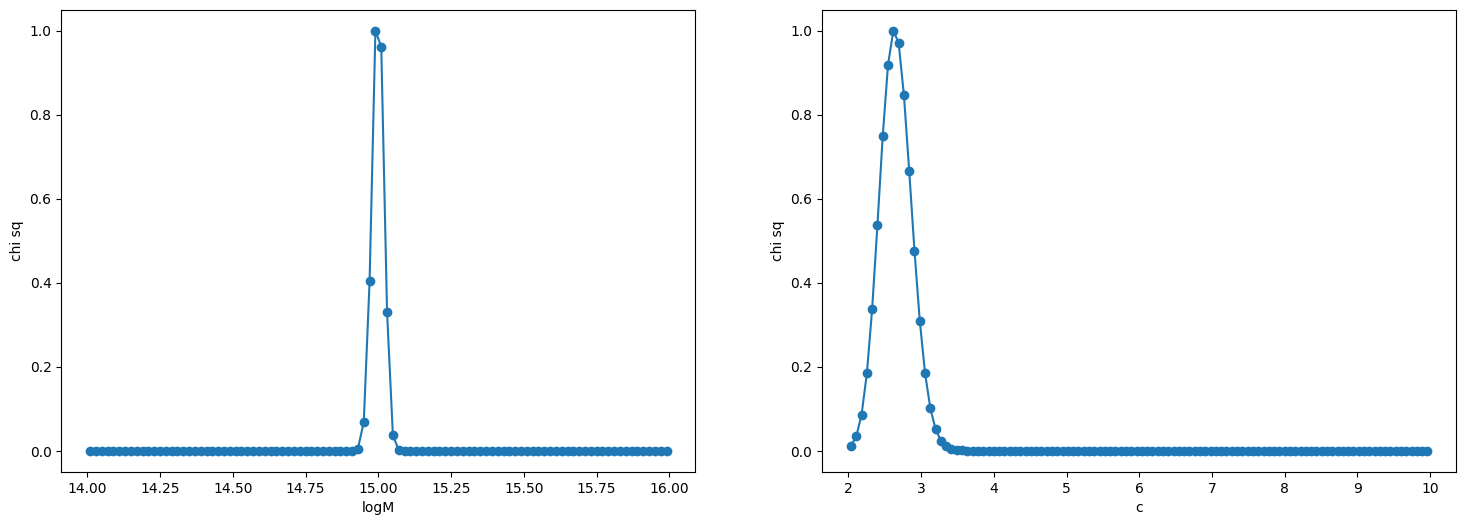

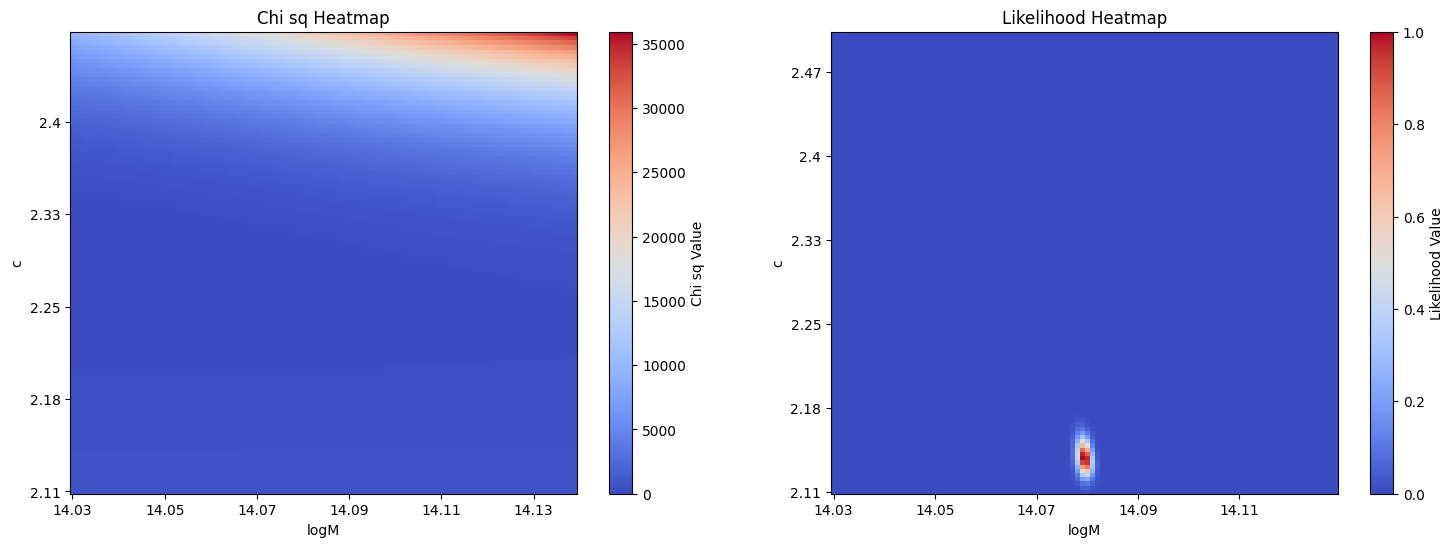

In [7]:
"Put your code here"
grid.plot1d()
grid.plot1d(marginalize=True)
grid.plot1d(likelihood=True)
grid.plot2d()

<h2>Metropolis Hastings Algorithm</h2>

Grid searches are robust, but not a very efficient way to determine the maximum likelihood (or posterior), especially for higher parametric problems. Gradient methods (generalizations of the Newton method) can efficiently search very big parameter spaces, but can - if one is interested in parameter errors - only be used in cases where the likelihood is sufficiently Gaussian and if no marginalization over nuisance parameters is desiered (nuisance parameters are parameters that are not of immediate interest to us, but will affect the errors of the parameters we're interested in). 

Markov chains can be used for small to medium sized parameter spaces to explore non-Gaussian likelihoods (i.e. cases where the likelihood has a complicated shape) and/or we need to marginalize over nuisance parameters (i.e. integrate the likelihood/posterior in certain dimensions).
For these cases one can explore the likelihood/posterior with the help of Markov chains, as we will do in the next step.

The `Sampler` class includes the functions to do a MCMC sampling and make some simple plots of the results. Again, the class is not complete yet. Look at the next few cells before you start coding.

In [5]:
class Sampler:
    
    def __init__(self, func):
        """
        Initialise Sampler
        Parameters:
        -----------
        log_prob: function that provides a log-likelihood to be sampled
        """
        self.log_prob = func
        

    def run_mcmc(self, p0, cov, n_samples):
        """
        Runs a Monte Carlo Markov Chain.

        Parameters:
        ----------
        p0         : initial parameters 
        cov        : covariance matrix of the proposal distribution 
        n_samples  : number of mcmc samples
        """    
        log_prob0 = self.log_prob(*p0) # initial parameters log likelihood
        
        samples = np.zeros((len(p0), n_samples)) # matrix for storing all sample points/candidates
        log_prob_arr = np.zeros(n_samples) # also store the values of the log-likelihood
        alpha = np.zeros(n_samples) # probability of accepting each candidate

        samples[:,0] = p0 # store initial parameters as first candidates
        log_prob_arr[0] = log_prob0 # store log likelihood of initial parameters
        accepted = 0 # counter of accpeted candidates
        x = p0
        
        for i in range(1, n_samples):
            y = np.random.multivariate_normal(x, cov)
            u = np.random.uniform()
            alpha[i] = np.min(np.array([1, np.exp(-self.log_prob(*y)+self.log_prob(*x))]))
            if u <= alpha[i]:
                x = y
                accepted += 1 
            else:
                pass
            samples[:,i] = x
            log_prob_arr[i] = self.log_prob(*x)
            
        self.chain = samples
        self.alpha = alpha
        self.log_prob_arr = log_prob_arr
        self.accepted = accepted


    
    def plot_chain(self, p_names=None, axes=None):
        """
        Plots the chain

        Parameters:
        ----------
        p_names (optional)      : provide parameter names for labeling the plot 
        other_chains (optional) : provide a list of chains from other samplers which 
                                  will be added to the plot
        """    
        n_p = self.chain.shape[0]
        n_rows = math.ceil(n_p/2)
        dx = figsize[0]/2
        dy = figsize[1]
        n_cols = 2 if n_p > 1 else 1

        if (p_names is not None) and (len(p_names) != n_p):
            raise Exception("labels for parameters don't match number of parameters in chain")
        if axes is None:
            _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*dx, n_rows*dy))
        for i, ax in enumerate(axes.flatten()):
            if i < n_p:
                ax.plot(self.chain[i,:])
                if p_names is not None:
                    ax.set_ylabel(p_names[i])
                    ax.set_xlabel('step number')
            else:
                del ax
        return axes
                
    def histogram(self, p_names=None, remove_burnin=0, axes=None):
        """
        Make a histogram of the chain

        Parameters:
        ----------
        p_names (optional)      : provide parameter names for labeling the plot 
        other_chains (optional) : provide a list of chains from other samplers which 
                                  will be added to the plot
        remove_burnin (optional, default=0) : how many steps to discard from the chain
        """    
        n_p = self.chain.shape[0]
        n_rows = math.ceil(n_p/2)
        dx = 9
        dy = 6
        n_cols = 2 if n_p > 1 else 1

        if (p_names is not None) and (len(p_names) != n_p):
            raise Exception("labels for parameters don't match number of parameters in chain")
        if axes is None:
            _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*dx, n_rows*dy))
        for i, ax in enumerate(axes.flatten()):
            if i < n_p:
                ax.hist(self.chain[i,remove_burnin:], histtype='step', bins=20, density=True)
                if p_names is not None:
                    ax.set_xlabel(p_names[i])
            else:
                del ax
        return axes

    def R_conv(self, x, n, m): 
        """
        x : matrix of chains
        n : length of chain
        m : number of chains
        """
        psi_m_cad = np.mean(x, axis = 1)
        
        psi_m_mean = np.mean(psi_m_cad)
        
        B_m = n / (m - 1.) * np.sum((psi_m_cad - psi_m_mean)**2)
        
        s2_m = 1. / (n - 1.) * np.sum((x[0, 0:n] - psi_m_cad[:, np.newaxis])**2, axis = 1)
        
        W_m = np.mean(s2_m)

        
        var_m = (n - 1.) / n * W_m + 1. / n * B_m
        R_m = np.sqrt(var_m / W_m)
        
        return R_m

    


Now, to complete the Sampler class, create an instance and get some samples. 

However, calculating the likelihood is quite slow. For a few grid point it's reasonably fast, but if you want to run $10^5$samples with an MCMC you'll have to wait for some time to see how your results look. Therefore you won't develop your sampler code with the true likelihood, but we will use your grid search results to define an approximated function with almost the same shape. This will be much faster and almost as good. Once you're happy with your sampler and the widths of the proposal distribution you will use the real likelihood.

You may have noticed a method get_gaussian_fit in the Grid_Search class. It is intended for just that purpose. Use it, to get the interpolated log likelihood for the grid search object you created before.

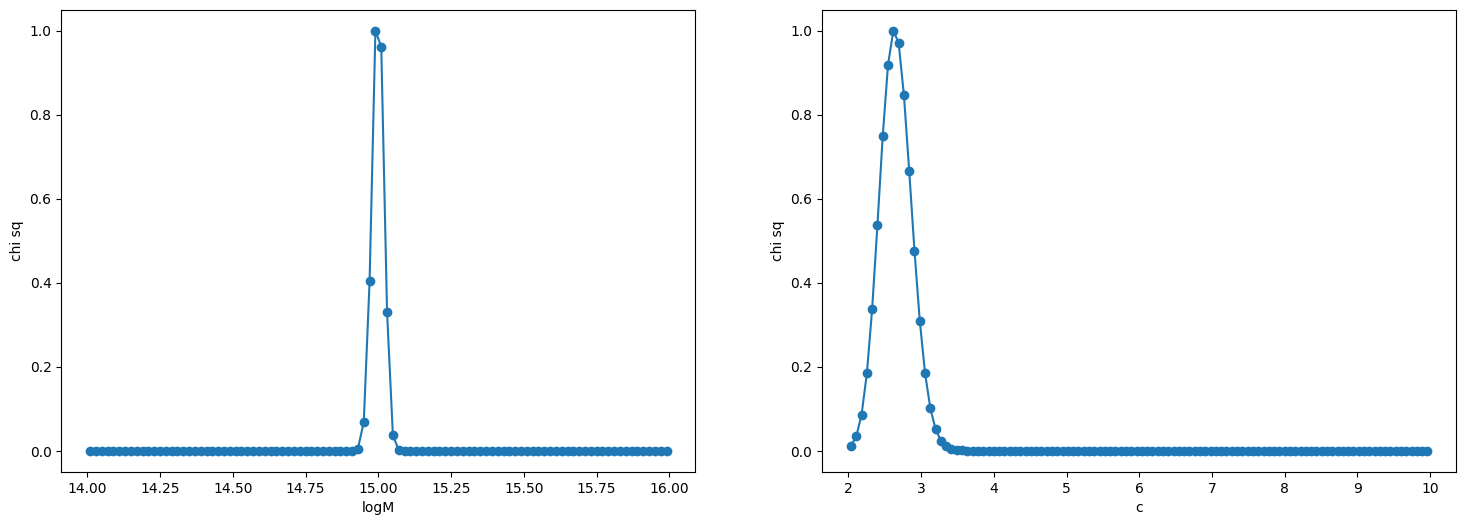

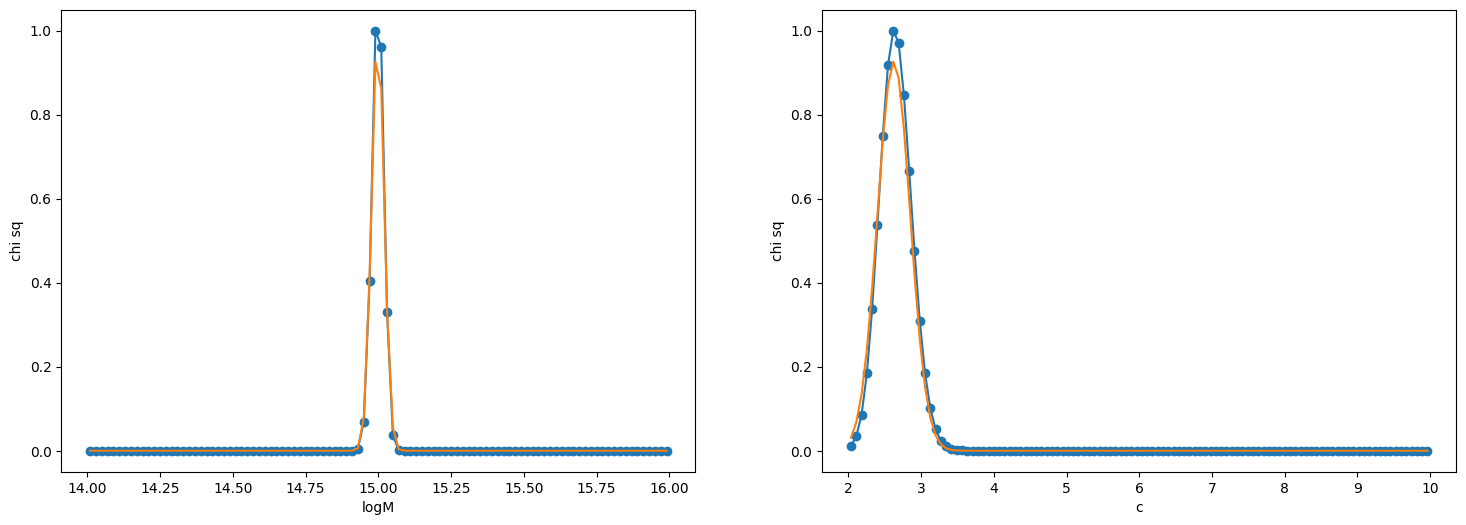

In [121]:
"Put the call of get_gaussian_fit here"
grid.plot1d(likelihood=True)
fitted_chi_sq_func, fitted_gaussian_func = grid.get_gaussian_fit(plot=True)
plt.savefig('gaussian_fit')



Verify visually that the approximation worked by once again looking at the curves around the best fit values.
Make four plots: one where you fix $c_{200}$ to the best fit value and vary $\log M_{200}$. And a second one where you fix $\log M_{200}$ to the best fit value and vary $c_{200}$. Make plots for both the $\chi^2$ and the likelihood.

It's time to run the sampler. Define a reasonable covariance. Do you have any idea what a __reasonably__ good numbers might be? Is there any way to find out from your previous results?

No need to fine tune the covariance yet. That'll happen in the next step. So first, initialize and run your sampler, then make plots of the chains. Once those look like they are converging, plot the likelihood.

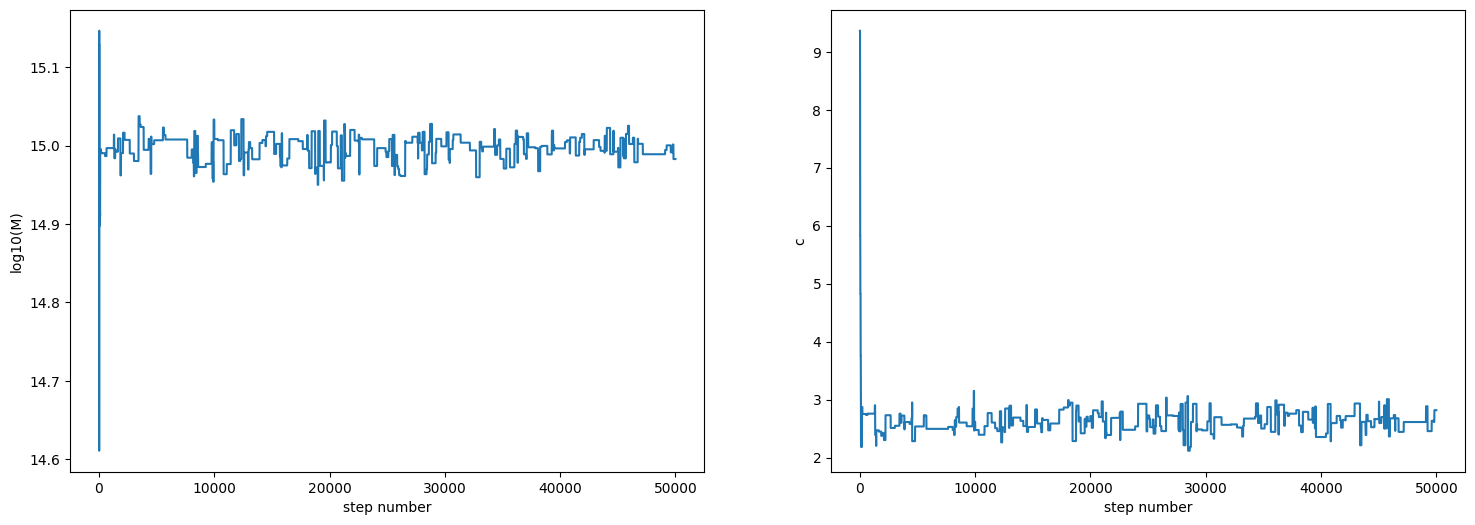

In [309]:
sampler = Sampler(fitted_chi_sq_func)
n_samples = 50000
p0 = cluster.get_random_parameter()
cov = np.diag((1, 1))
sampler.run_mcmc(p0, cov, n_samples)
sampler.plot_chain(p_names = np.array(['log10(M)', 'c']))
plt.savefig('chain1_fitted')

In [310]:
print(np.mean(sampler.alpha))
print(sampler.accepted)
acceptance_rate = sampler.accepted/n_samples
print(acceptance_rate)

0.004635968247883136
236
0.00472


In [311]:
def gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2.*sigma**2))

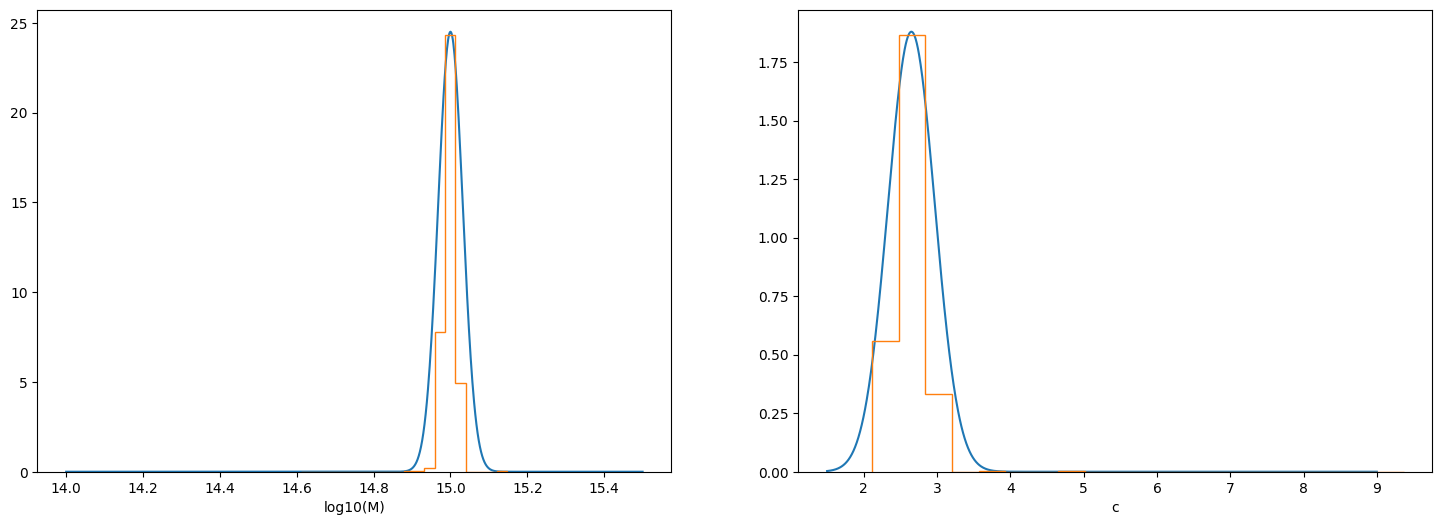

In [360]:

f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


x = np.linspace(14, 15.5, 1000)
ax1.plot(x, gauss(x, 24.5, 15.0, 0.032))
#ax1.plot(x, stats.norm.pdf(x, 14.9, 0.03))

x = np.linspace(1.5, 9, 1000)
ax2.plot(x, gauss(x, 1.88, 2.65, 0.32))


sampler.histogram(axes = np.array([ax1, ax2]), p_names = np.array(['log10(M)', 'c']))
plt.savefig('hist1')

Once your likelihood looks good, we'll take a look at how how different covariances affect the chain. Define three samplers and run them with different covariances. Make plots of the chains and histograms of the samples. Finally, make a 2d-plot of the likelihood to compare it to the plot you made for the grid search.

C:\Users\pablo\AppData\Local\Temp\ipykernel_9152\2101235888.py:37: RuntimeWarning: overflow encountered in exp
  alpha[i] = np.min(np.array([1, np.exp(-self.log_prob(*y)+self.log_prob(*x))]))


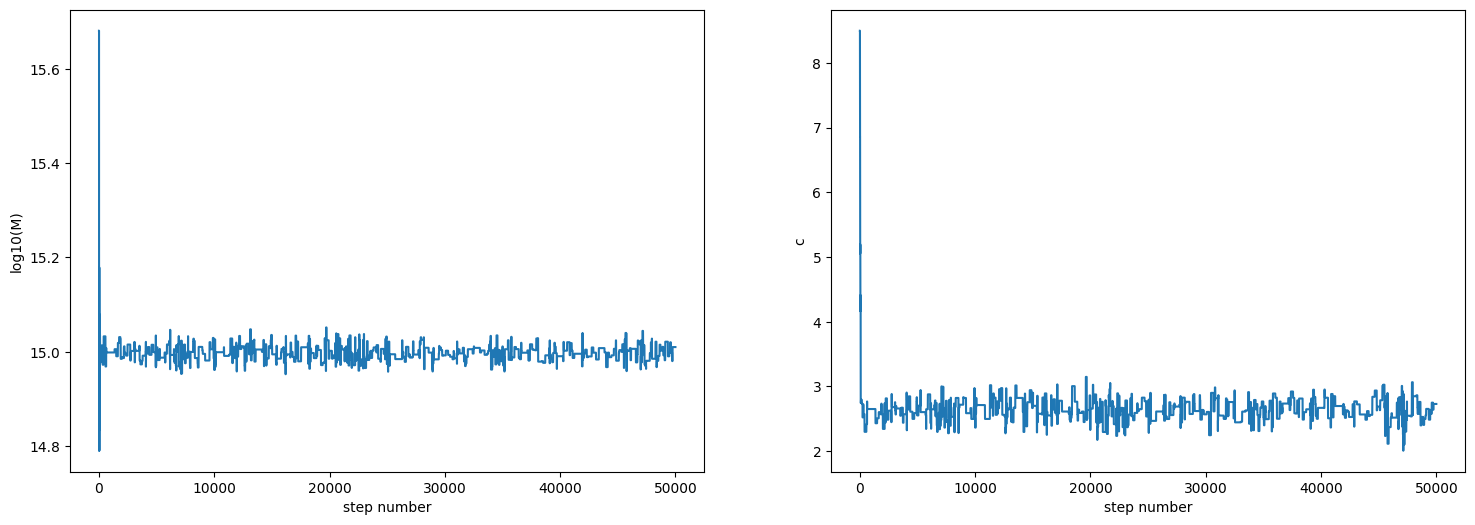

In [252]:
"Put your code here"
cov1 = 0.5 *  np.diag((1, 1))
#cov1 = np.array([[1.0, 0.75], [0.75, 1.0]])
sampler.run_mcmc(p0, cov1, n_samples)
sampler.plot_chain(p_names = np.array(['log10(M)', 'c']))
plt.savefig('chain2_fitted')

In [253]:
print(np.mean(sampler.alpha))
print(sampler.accepted)
acceptance_rate = sampler.accepted/n_samples
print(acceptance_rate)

0.010068730514572077
534
0.01068


array([<Axes: >, <Axes: >], dtype=object)

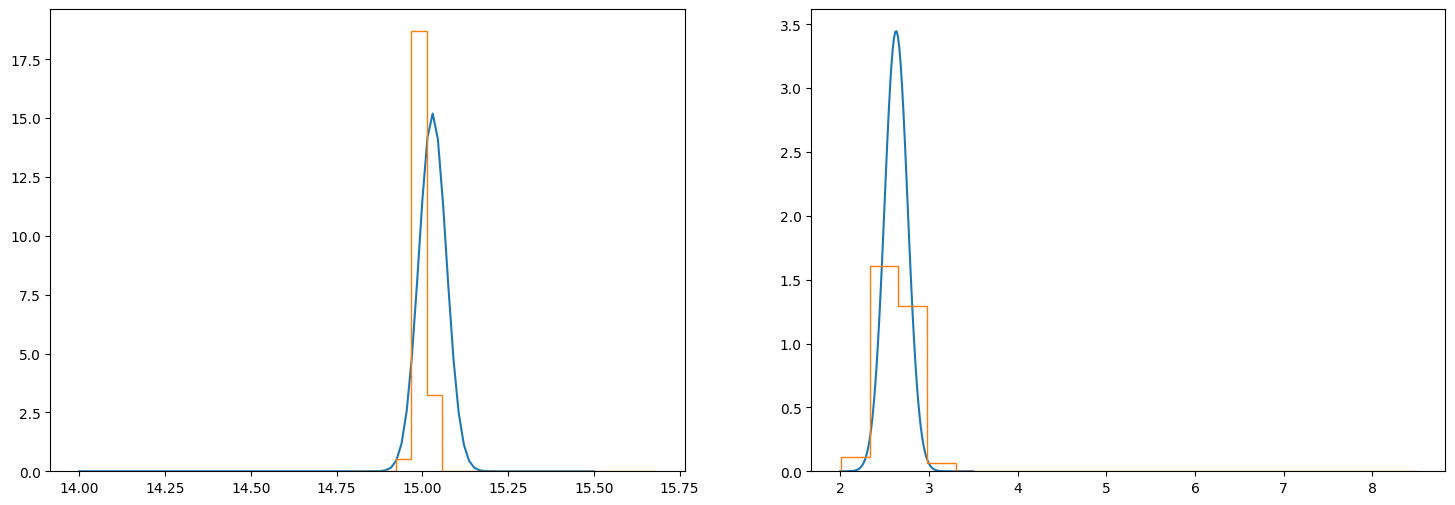

In [254]:

f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


x = np.linspace(14, 15.5, 100)
ax1.plot(x, gauss(x, 15.2, 15.03, 0.04))

x = np.linspace(2, 3.5, 100)
ax2.plot(x, gauss(x, 3.45, 2.63, 0.13))

sampler.histogram(axes = np.array([ax1, ax2]))

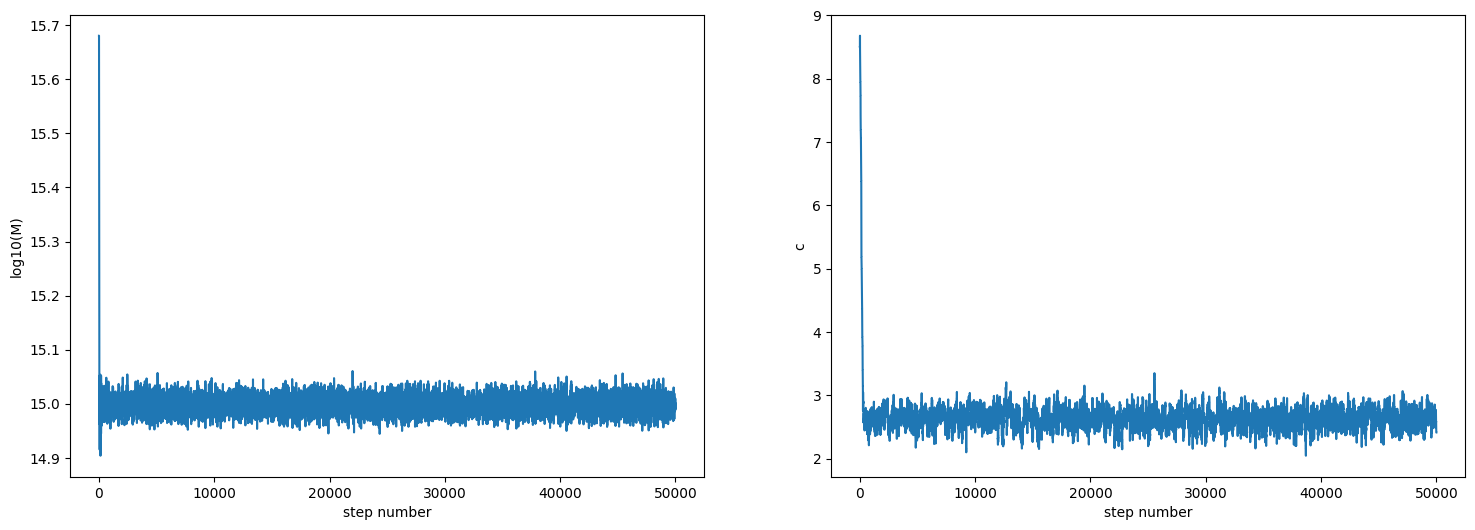

In [259]:
"Put your code here"
cov1 = 0.01 *  np.diag((1, 1))
#cov1 = np.array([[1.0, 0.75], [0.75, 1.0]])
sampler.run_mcmc(p0, cov1, n_samples)
sampler.plot_chain(p_names = np.array(['log10(M)', 'c']))
plt.savefig('chain4_fitted')

In [260]:
print(np.mean(sampler.alpha))
print(sampler.accepted)
acceptance_rate = sampler.accepted/n_samples
print(acceptance_rate)

0.17074140725934522
8525
0.1705


In [ ]:
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


x = np.linspace(14, 15.5, 100)
ax1.plot(x, gauss(x, 15.2, 15.03, 0.04))

x = np.linspace(2, 3.5, 100)
ax2.plot(x, gauss(x, 3.45, 2.63, 0.13))

sampler.histogram(axes = np.array([ax1, ax2]))

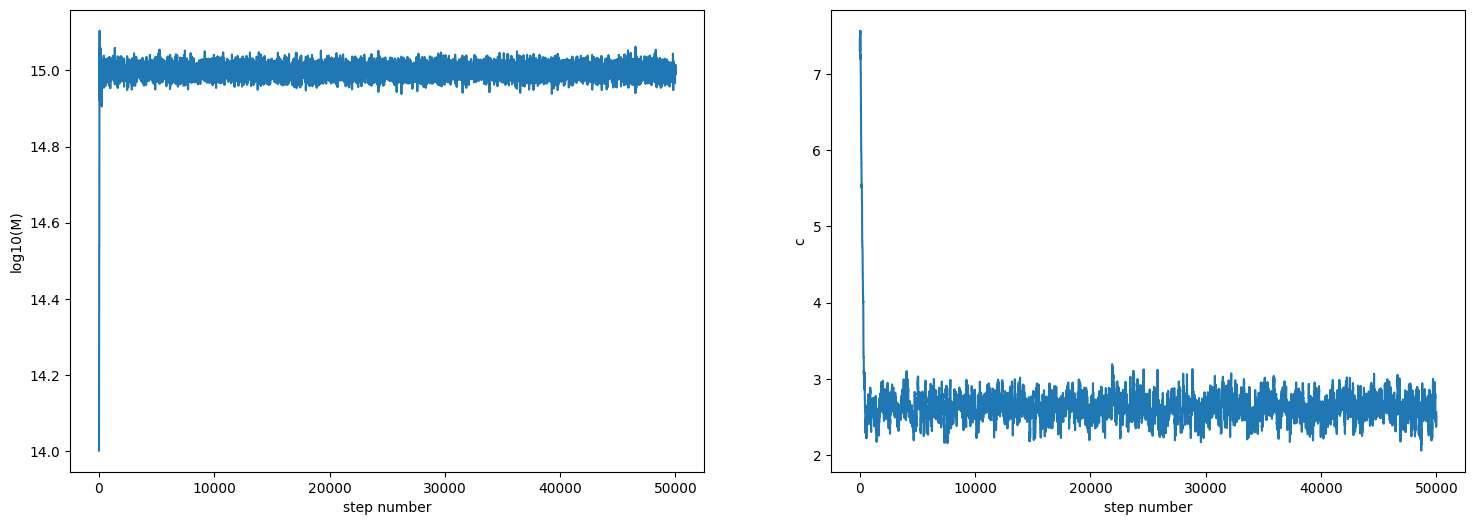

In [388]:
cov2 = 0.0055 *  np.diag((1, 1))
p0 = cluster.get_random_parameter()
sampler.run_mcmc(p0, cov2, n_samples)
sampler.plot_chain(p_names = np.array(['log10(M)', 'c']))
plt.savefig('chain5_fitted')

In [389]:
print(np.mean(sampler.alpha))
print(sampler.accepted)
acceptance_rate = sampler.accepted/n_samples
print(acceptance_rate)

0.23189898171137685
11592
0.23184


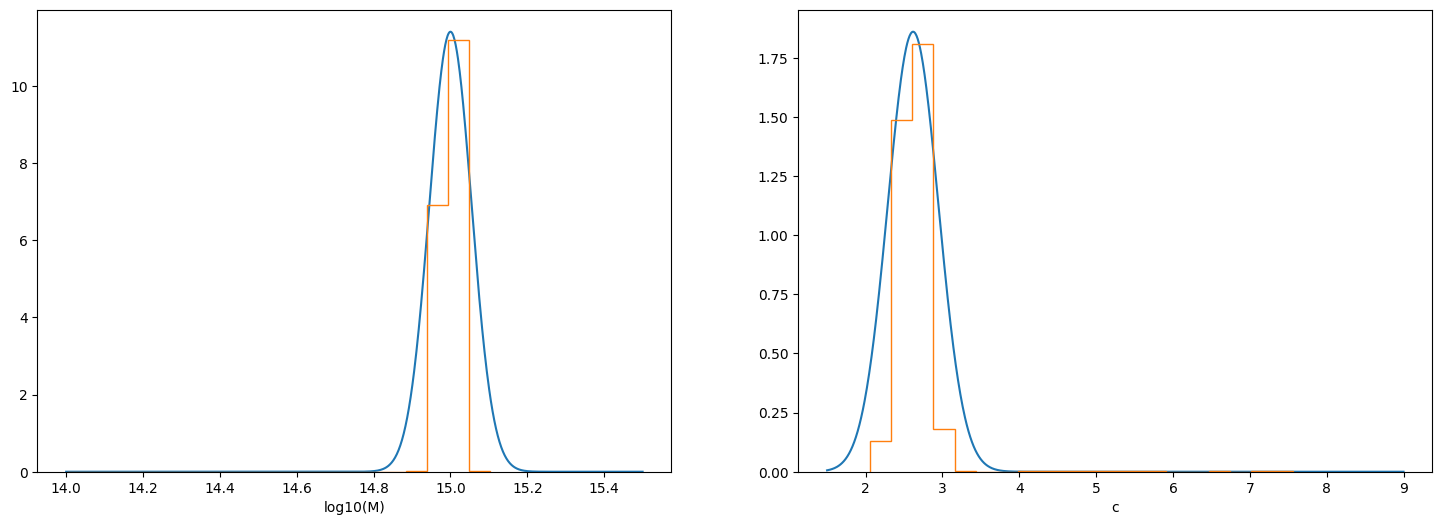

In [414]:
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


x = np.linspace(14, 15.5, 1000)
ax1.plot(x, gauss(x, 11.4, 15.0, 0.055))

x = np.linspace(1.5, 9, 1000)
ax2.plot(x, gauss(x, 1.86, 2.619, 0.33))

sampler.histogram(axes = np.array([ax1, ax2]), p_names = np.array(['log10(M)', 'c']))
plt.savefig('hist_chain5')

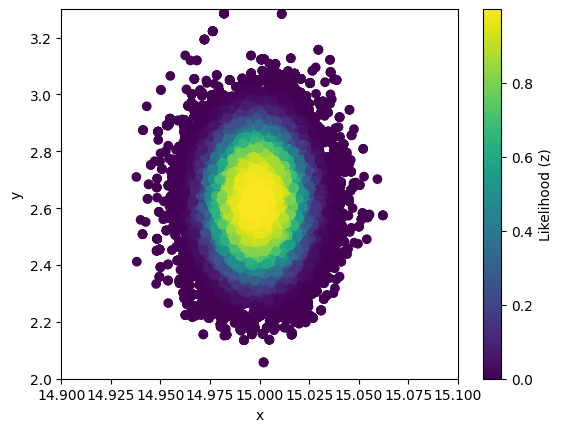

In [419]:
plt.scatter(sampler.chain[0,:], sampler.chain[1,:], c=np.exp(-0.5*sampler.log_prob_arr**2), cmap='viridis')  # 'viridis' is just an example of a colormap
plt.colorbar(label='Likelihood (z)')
plt.ylim((2,3.3))
plt.xlim((14.9, 15.1))
plt.xlabel('logM')
plt.ylabel('c')
#plt.title('Scatter Plot with Color Mapping')
plt.savefig('2d_scatter')
plt.show()


array([<Axes: >, <Axes: >], dtype=object)

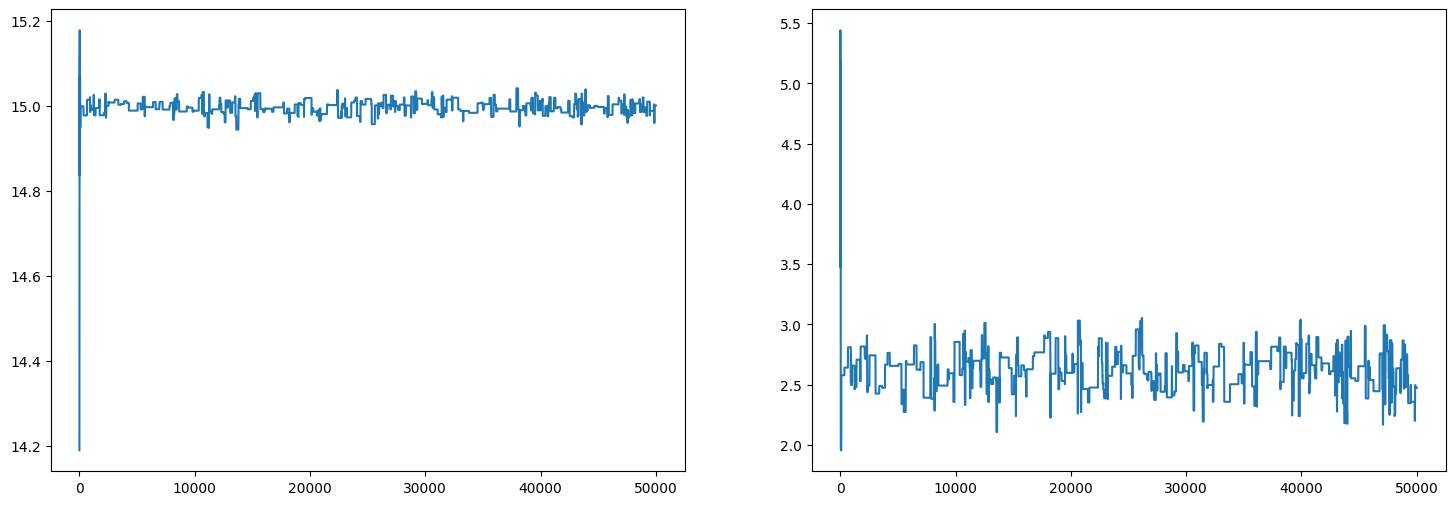

In [158]:
cov3 = np.array([[0.5, 0.25], [0.25, 1.0]])
sampler.run_mcmc(p0, cov3, n_samples)
sampler.plot_chain(p_names = np.array(['log10(M)', 'c']))

In [159]:
np.mean(sampler.log_prob_arr)

np.float64(0.00904513940769431)

array([<Axes: >, <Axes: >], dtype=object)

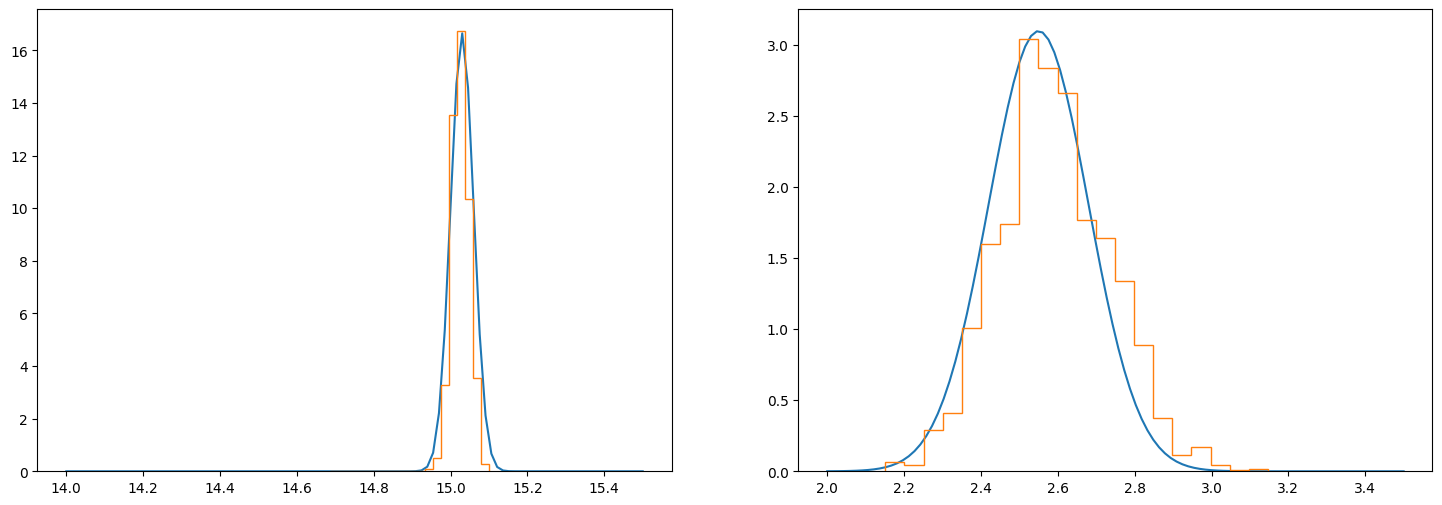

In [231]:
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)


x = np.linspace(14, 15.5, 100)
ax1.plot(x, gauss(x, 16.65, 15.03, 0.03))

x = np.linspace(2, 3.5, 100)
ax2.plot(x, gauss(x, 3.1, 2.55, 0.13))

sampler.histogram(axes = np.array([ax1, ax2]))

Finally, once you have settled on a good covariance, it is time to run the MCMC for the __full__ data set on the __real__ likelihood, not the interpolated one. 

In [36]:
print(fitted_chi_sq_func(14,2), cluster.log_prob(14, 2))

171.21578730959723 628313.7720333026


Now generate at least 5 different chains and analyze them. Do not forget to include a check for convergence - add a method to the sampler class to do so.

 60%|██████████████████████████████████████████████▊                               | 3/5 [1:31:50<1:04:57, 1948.61s/it]C:\Users\pablo\AppData\Local\Temp\ipykernel_26844\2101235888.py:37: RuntimeWarning: overflow encountered in exp
  alpha[i] = np.min(np.array([1, np.exp(-self.log_prob(*y)+self.log_prob(*x))]))
100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [3:10:16<00:00, 2283.26s/it]


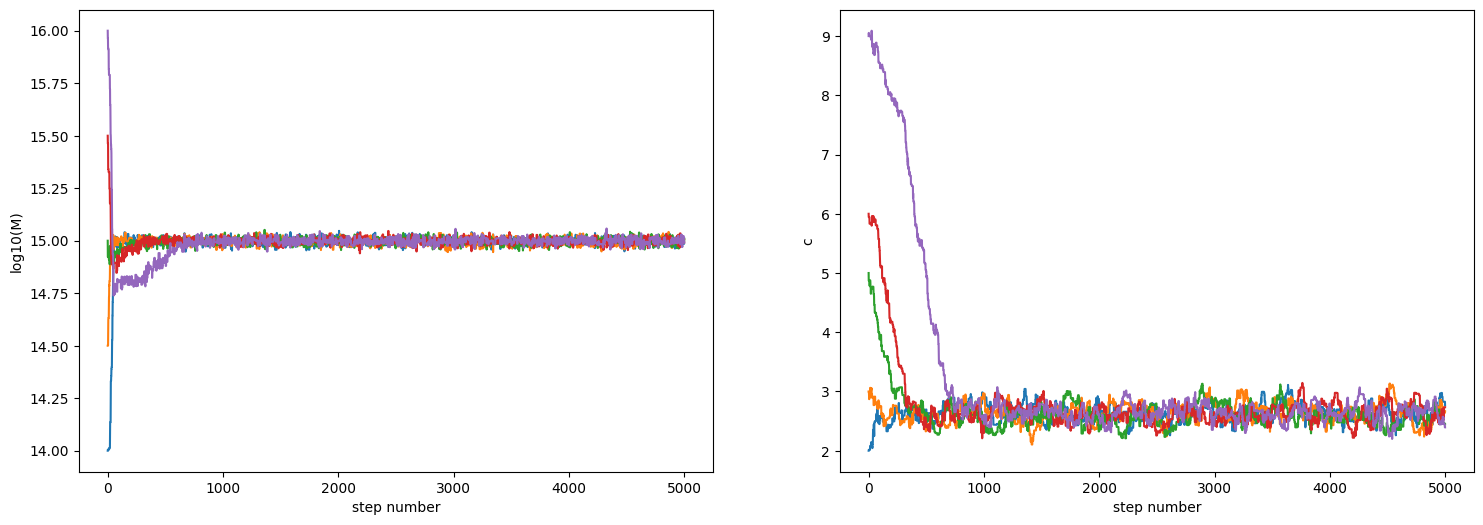

In [6]:
"Put your code here"
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

n_samples = 5000
n_chains = 5
p0 = np.array([[14.,2.], [14.5,3.], [15.,5.], [15.5,6.], [16.,9.]])
psi_m = np.zeros((n_chains, n_samples))
psi_c = np.zeros((n_chains, n_samples))

cov_def = 0.0055 *  np.diag((1, 1))
sampler = Sampler(cluster.log_prob)
for i in tqdm(range(n_chains)):
    sampler.run_mcmc(p0[i,:], cov_def, n_samples)
    sampler.plot_chain(axes = np.array([ax1, ax2]), p_names = np.array(['log10(M)', 'c']))
    psi_m[i,:] = sampler.chain[0,:]
    psi_c[i,:] = sampler.chain[1,:]
    

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [46:49<29:20, 880.34s/it]C:\Users\pablo\AppData\Local\Temp\ipykernel_26844\2101235888.py:37: RuntimeWarning: overflow encountered in exp
  alpha[i] = np.min(np.array([1, np.exp(-self.log_prob(*y)+self.log_prob(*x))]))
100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:19:41<00:00, 956.27s/it]


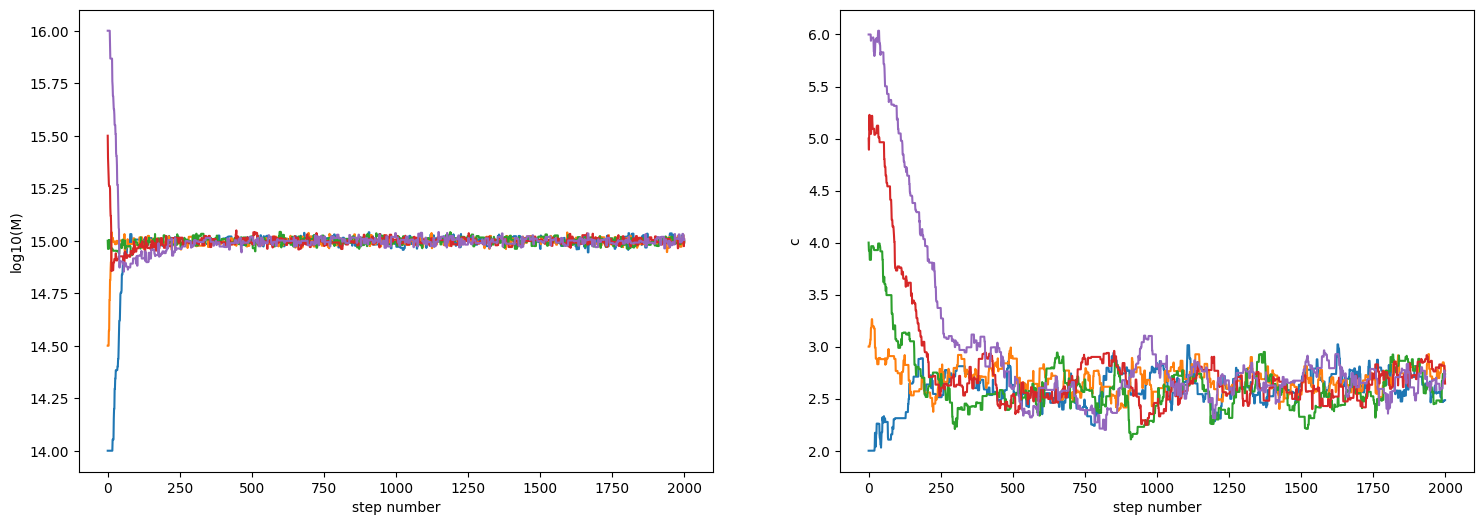

In [16]:
"Put your code here"
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

n_samples = 2000
n_chains = 5
p0 = np.array([[14.,2.], [14.5,3.], [15.,4.], [15.5,5.], [16.,6.]])
psi_m = np.zeros((n_chains, n_samples))
psi_c = np.zeros((n_chains, n_samples))

cov_def = 0.0055 *  np.diag((1, 1))
sampler2 = Sampler(cluster.log_prob)
for i in tqdm(range(n_chains)):
    sampler2.run_mcmc(p0[i,:], cov_def, n_samples)
    sampler2.plot_chain(axes = np.array([ax1, ax2]), p_names = np.array(['log10(M)', 'c']))
    psi_m[i,:] = sampler2.chain[0,:]
    psi_c[i,:] = sampler2.chain[1,:]

In [32]:
sampler2.R_conv(psi_m, n_samples, n_chains)

np.float64(1.0931912379311521)

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [15:48<10:34, 317.22s/it]C:\Users\pablo\AppData\Local\Temp\ipykernel_26844\2101235888.py:37: RuntimeWarning: overflow encountered in exp
  alpha[i] = np.min(np.array([1, np.exp(-self.log_prob(*y)+self.log_prob(*x))]))
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [26:18<00:00, 315.72s/it]


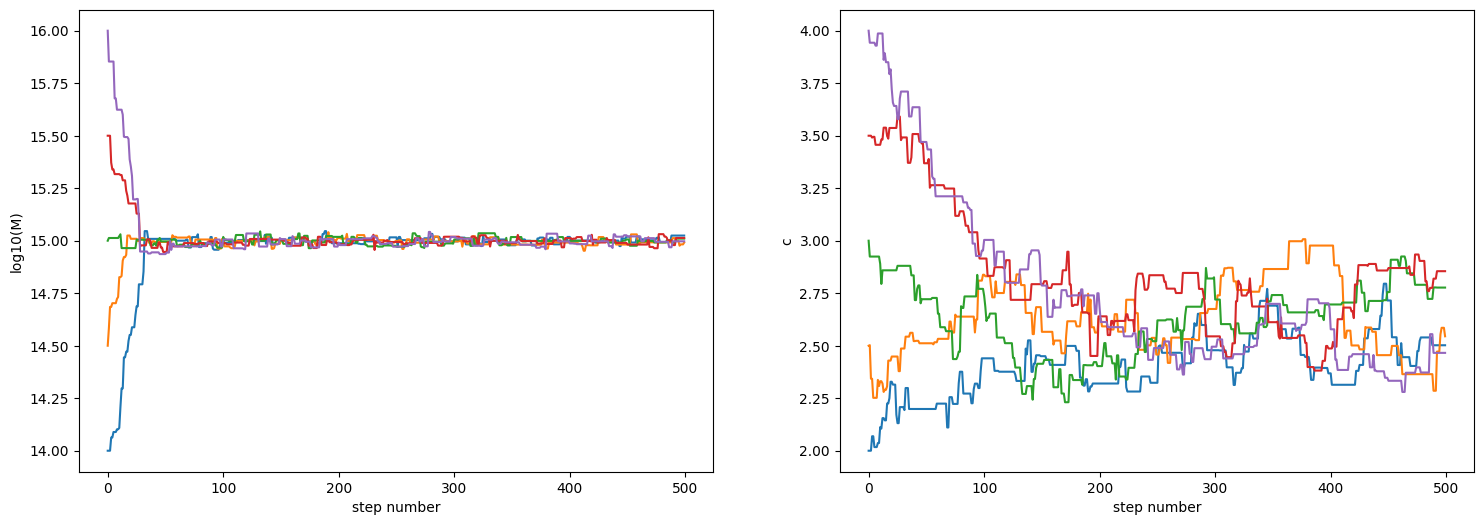

In [33]:
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

n_samples = 500
n_chains = 5
p0 = np.array([[14.,2.], [14.5,2.5], [15.,3.], [15.5,3.5], [16.,4.]])
psi_m500 = np.zeros((n_chains, n_samples))
psi_c500 = np.zeros((n_chains, n_samples))

cov_def = 0.0055 *  np.diag((1, 1))
sampler3 = Sampler(cluster.log_prob)
for i in tqdm(range(n_chains)):
    sampler3.run_mcmc(p0[i,:], cov_def, n_samples)
    sampler3.plot_chain(axes = np.array([ax1, ax2]), p_names = np.array(['log10(M)', 'c']))
    psi_m500[i,:] = sampler3.chain[0,:]
    psi_c500[i,:] = sampler3.chain[1,:]

In [35]:
sampler3.R_conv(psi_c500, n_samples, n_chains)

np.float64(1.1223816780106932)

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [10:56<02:46, 166.16s/it]C:\Users\pablo\AppData\Local\Temp\ipykernel_26844\2101235888.py:37: RuntimeWarning: overflow encountered in exp
  alpha[i] = np.min(np.array([1, np.exp(-self.log_prob(*y)+self.log_prob(*x))]))
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:37<00:00, 163.47s/it]


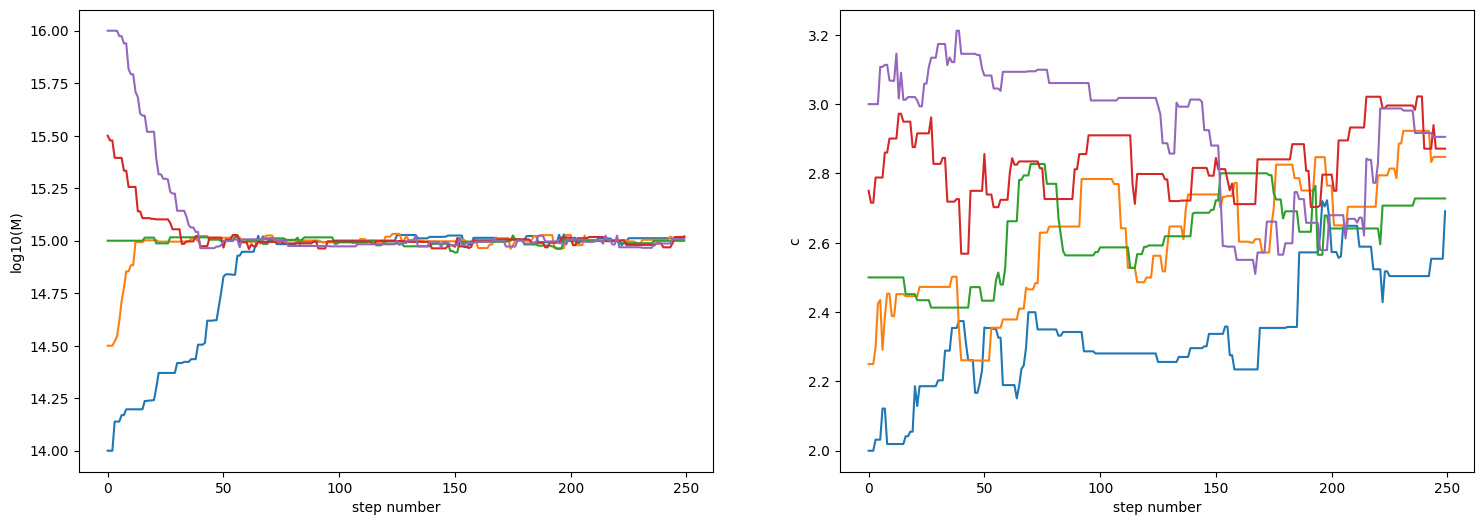

In [36]:
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

n_samples = 250
n_chains = 5
p0 = np.array([[14.,2.], [14.5,2.25], [15.,2.5], [15.5,2.75], [16.,3.]])
psi_m250 = np.zeros((n_chains, n_samples))
psi_c250 = np.zeros((n_chains, n_samples))

cov_def = 0.0055 *  np.diag((1, 1))
sampler4 = Sampler(cluster.log_prob)
for i in tqdm(range(n_chains)):
    sampler4.run_mcmc(p0[i,:], cov_def, n_samples)
    sampler4.plot_chain(axes = np.array([ax1, ax2]), p_names = np.array(['log10(M)', 'c']))
    psi_m250[i,:] = sampler4.chain[0,:]
    psi_c250[i,:] = sampler4.chain[1,:]

In [38]:
sampler4.R_conv(psi_c250, n_samples, n_chains)

np.float64(1.134850529447323)

 67%|████████████████████████████████████████████████████████                            | 2/3 [02:24<01:11, 71.50s/it]C:\Users\pablo\AppData\Local\Temp\ipykernel_26844\2101235888.py:37: RuntimeWarning: overflow encountered in exp
  alpha[i] = np.min(np.array([1, np.exp(-self.log_prob(*y)+self.log_prob(*x))]))
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:29<00:00, 69.76s/it]


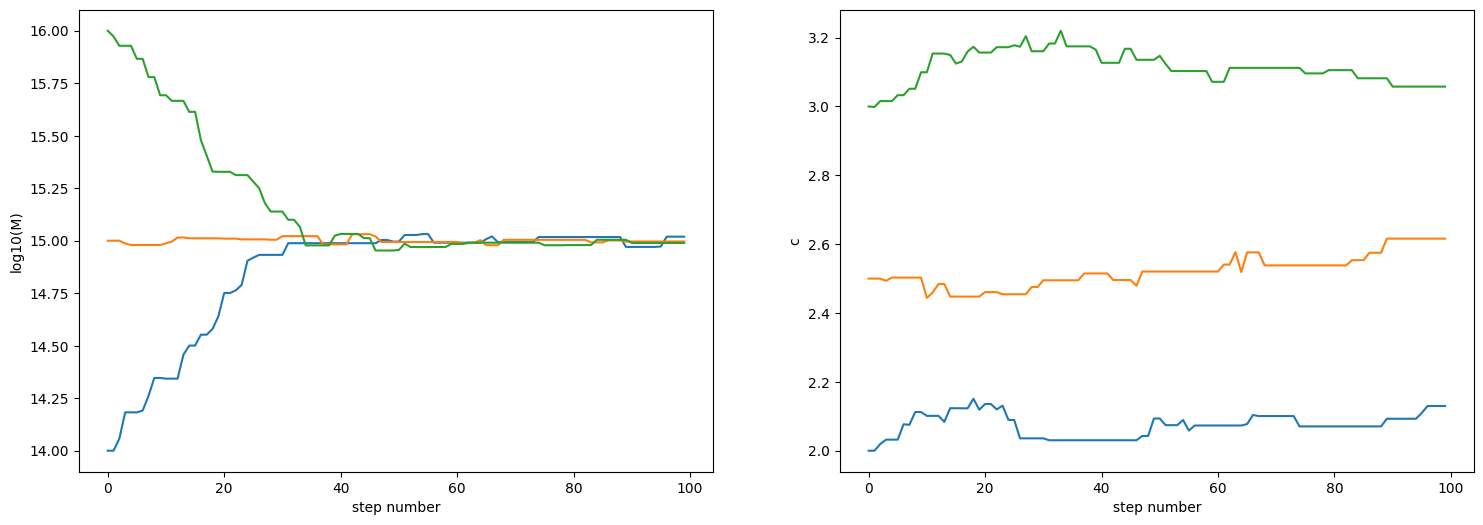

In [25]:
"Put your code here"
f = plt.figure(figsize = (18,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

n_samples = 100
n_chains = 3
p0 = np.array([[14.,2.], [15.,2.5], [16, 3.]])
psi_m = np.zeros((n_chains, n_samples))
psi_c = np.zeros((n_chains, n_samples))

cov_def = 0.0055 *  np.diag((1, 0.1))
sampler5 = Sampler(cluster.log_prob)
for i in tqdm(range(n_chains)):
    sampler5.run_mcmc(p0[i,:], cov_def, n_samples)
    sampler5.plot_chain(axes = np.array([ax1, ax2]), p_names = np.array(['log10(M)', 'c']))
    psi_m[i,:] = sampler5.chain[0,:]
    psi_c[i,:] = sampler5.chain[1,:]

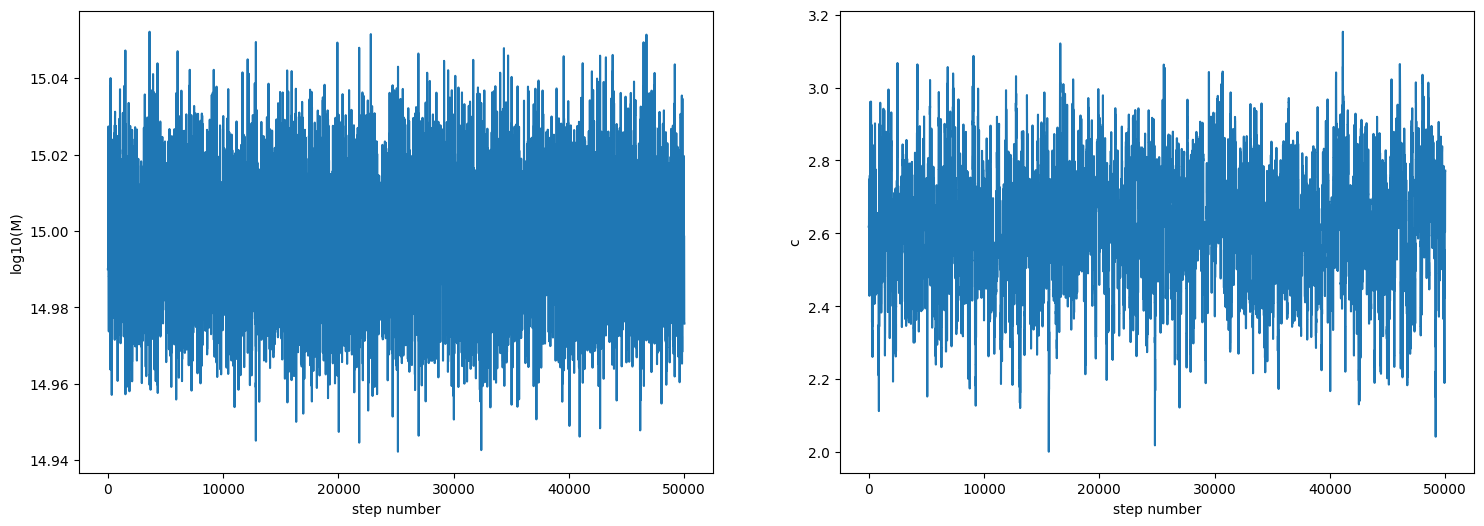

In [281]:
sampler = Sampler(fitted_chi_sq_func)
n_samples = 50000
p0 = grid.x[grid.ix_min], grid.y[grid.iy_min]
cov = 0.01*np.diag((1, 1))
sampler.run_mcmc(p0, cov, n_samples)
sampler.plot_chain(p_names = np.array(['log10(M)', 'c']))
plt.savefig('chi_min_choice')